<a href="https://colab.research.google.com/github/ayulockin/LossLandscape/blob/master/MediumCNN_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setups, Installations and Imports

In [1]:
!nvidia-smi

Wed Jul 22 10:14:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
## This is so that I can save my models.
from google.colab import drive
drive.mount('gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at gdrive


In [4]:
%%capture 
!pip install wandb

In [5]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import resnet50

import tensorflow_addons as tfa

In [6]:
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import io
import itertools
from sklearn.metrics import confusion_matrix

In [7]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Download and Prepare Dataset

#### CIFAR-10

In [8]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

CLASS_NAMES = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

170500096/170498071 [==============================] - 11s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


#### Dataloader

In [9]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128
IMG_SHAPE = 32

trainloader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
testloader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

def preprocess_image(image, label):
  img = tf.cast(image, tf.float32)
  img = img/255.

  return img, label

trainloader = (
    trainloader
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testloader = (
    testloader
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Model

In [10]:
def Model():
  inputs = keras.layers.Input(shape=(IMG_SHAPE, IMG_SHAPE, 3))

  x = keras.layers.Conv2D(32,(3,3), padding='same')(inputs)
  x = keras.activations.relu(x)
  x = keras.layers.Dropout(0.1)(x)
  x = keras.layers.MaxPooling2D(2)(x)

  x = keras.layers.Conv2D(64,(3,3), padding='valid')(x)
  x = keras.activations.relu(x)
  x = keras.layers.Dropout(0.1)(x)
  x = keras.layers.MaxPooling2D(2)(x)

  x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
  x = keras.activations.relu(x)
  x = keras.layers.Dropout(0.1)(x)
  x = keras.layers.MaxPooling2D(2)(x)

  x = keras.layers.Conv2D(128,(3,3), padding='same')(x)
  x = keras.activations.relu(x)
  x = keras.layers.Dropout(0.1)(x)
  x = keras.layers.MaxPooling2D(2)(x)

  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(32, activation='relu')(x)
  x = keras.layers.Dropout(0.1)(x)
  
  outputs = keras.layers.Dense(10, activation='softmax')(x)

  return keras.models.Model(inputs=inputs, outputs=outputs)

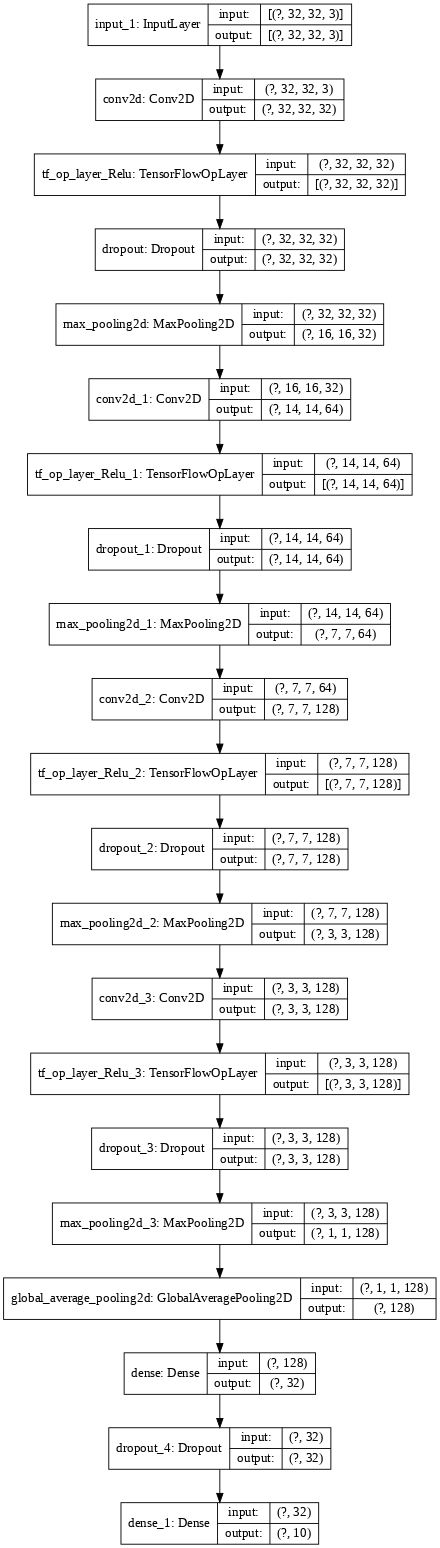

In [11]:
tf.keras.backend.clear_session()
model = Model()

tf.keras.utils.plot_model(
    model, to_file='small_cnn.png', show_shapes=True, show_layer_names=True, dpi=65
)

# Callbacks

#### LR Scheduler

In [12]:
# Custom LR schedule as mentioned in the LossLandscape paper
LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (0, 1.6*1e-3),
    (9, (1.6*1e-3)/2),
    (19, (1.6*1e-3)/4),
    (29, (1.6*1e-3)/8),
]

def lr_schedule(epoch):
    if (epoch >= 0) & (epoch < 9):
        return LR_SCHEDULE[0][1]
    elif (epoch >= 9) & (epoch < 19):
        return LR_SCHEDULE[1][1]
    elif (epoch >= 19) & (epoch < 29):
        return LR_SCHEDULE[2][1]
    else:
        return LR_SCHEDULE[3][1]

lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr_schedule(epoch), verbose=True)

#### Model Checkpoint

In [13]:
SAVE_PATH = 'gdrive/My Drive/LossLandscape/MediumCNN_CheckpointID_1/'

In [14]:
def save_model(epoch, logs):
  model.save(SAVE_PATH+'medium_cnn_checkpoint_{}.h5'.format(epoch))

save_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=save_model, verbose=True)

#### Confusion Matrix

In [15]:
def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    return figure

def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=3)
    # Convert back to NumPy
    image = image.numpy()
    return image

def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the validation dataset
    test_pred_raw = model.predict(x_test)
    test_pred = np.argmax(test_pred_raw, axis=1)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, test_pred)
    # Log the confusion matrix as an image to wandb
    figure = plot_confusion_matrix(cm, class_names=CLASS_NAMES)
    cm_image = plot_to_image(figure)
    wandb.log({'confusion_matrix': wandb.Image(cm_image)})

cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix, verbose=True)

# Initialize Model

In [ ]:
keras.backend.clear_session()
model = Model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
tf_op_layer_Relu (TensorFlow [(None, 32, 32, 32)]      0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
tf_op_layer_Relu_1 (TensorFl [(None, 14, 14, 64)]      0     

# Compile

In [ ]:
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])

# Wandb Init

In [ ]:
wandb.init(entity='authors', project='loss-landscape')

W&B Run: https://app.wandb.ai/authors/loss-landscape/runs/2l6onb0z

# Train

In [ ]:
EPOCHS = 40

start = time.time()
_ = model.fit(trainloader,
          epochs=EPOCHS,
          validation_data=testloader,
          callbacks=[WandbCallback(),
                     lr_callback,
                     cm_callback,
                     save_callback])
end = time.time()
print("Network takes {:.3f} seconds to train".format(end - start))
wandb.log({'training_time': end - start})
wandb.log({'nb_model_params': model.count_params()})


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0016.
Epoch 1/40
391/391 [==============================] - 7s 17ms/step - loss: 1.7086 - accuracy: 0.3659 - val_loss: 1.4096 - val_accuracy: 0.5127 - lr: 0.0016

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0016.
Epoch 2/40
391/391 [==============================] - 6s 15ms/step - loss: 1.3055 - accuracy: 0.5272 - val_loss: 1.2277 - val_accuracy: 0.5725 - lr: 0.0016

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0016.
Epoch 3/40
391/391 [==============================] - 6s 15ms/step - loss: 1.1221 - accuracy: 0.6012 - val_loss: 1.0516 - val_accuracy: 0.6449 - lr: 0.0016

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0016.
Epoch 4/40
391/391 [==============================] - 6s 14ms/step - loss: 0.9962 - accuracy: 0.6472 - val_loss: 0.9376 - val_accuracy: 0.6848 - lr: 0.0016

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0016.
Epoch 5/40
391/391 [======

# Evaluate

In [ ]:
loss, accuracy = model.evaluate(testloader, callbacks=[WandbCallback()])
print("Test Error Rate: ", round((1-accuracy)*100, 2), '%')
wandb.log({'Test Error Rate': round((1-accuracy)*100, 2)})

79/79 [==============================] - 0s 6ms/step - loss: 0.7532 - accuracy: 0.7797
Test Error Rate:  22.03 %


# Independent Solutions

In [ ]:
# Saving 10 independent solutions i.e, 10 different inits.
# Will save last model snapshot. 

EPOCHS = 40
SAVE_PATH = 'gdrive/My Drive/LossLandscape/MediumIndependentSolutions/'

for iter in range(10):
  # wandb init
  wandb.init(entity='authors', project='loss-landscape', id=wandb.util.generate_id())
  # initialize weights
  keras.backend.clear_session()
  model = Model()
  # compile
  model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
  # train
  _ = model.fit(trainloader,
              epochs=EPOCHS,
              validation_data=testloader,
              callbacks=[WandbCallback(),
                        lr_callback],
              verbose=0)
  # save final model snapshot
  model.save(SAVE_PATH+'mediumcnn_independent_model_{}.h5'.format(iter))
  # evaluate
  loss, accuracy = model.evaluate(testloader, callbacks=[WandbCallback()], verbose=0)
  print("Test Error Rate: ", round((1-accuracy)*100, 2), '% | Iteration No: ', iter)
  wandb.log({'Test Error Rate': round((1-accuracy)*100, 2)})


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00007: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00008: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00009: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00010: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00011: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00012: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00013: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00014: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00015: Learni


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00007: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00008: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00009: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00010: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00011: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00012: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00013: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00014: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00015: Learni


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00007: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00008: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00009: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00010: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00011: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00012: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00013: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00014: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00015: Learni


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00007: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00008: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00009: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00010: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00011: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00012: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00013: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00014: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00015: Learni


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00007: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00008: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00009: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00010: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00011: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00012: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00013: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00014: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00015: Learni


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00007: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00008: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00009: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00010: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00011: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00012: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00013: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00014: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00015: Learni


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00007: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00008: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00009: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00010: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00011: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00012: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00013: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00014: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00015: Learni


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00007: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00008: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00009: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00010: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00011: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00012: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00013: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00014: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00015: Learni


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00007: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00008: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00009: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00010: LearningRateScheduler reducing learning rate to 0.0008.


# For t-SNE Plot

In [16]:
# Saving all checkpoints for 3 independent solutions i.e, 3 different inits.

EPOCHS = 40
ROOT_SAVE_PATH = 'gdrive/My Drive/LossLandscape/MediumIndependentSolutions_tsne/'

for iter in range(3):
  try:
    os.mkdir(ROOT_SAVE_PATH+'Solution_{}'.format(iter))
  except:
    break

  SAVE_PATH = ROOT_SAVE_PATH+'Solution_{}/'.format(iter)

  # wandb init
  wandb.init(entity='authors', project='loss-landscape', id=wandb.util.generate_id())
  # initialize weights
  keras.backend.clear_session()
  model = Model()
  # compile
  model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
  # train
  _ = model.fit(trainloader,
              epochs=EPOCHS,
              validation_data=testloader,
              callbacks=[WandbCallback(),
                        lr_callback,
                        save_callback],
              verbose=0)
  # evaluate
  loss, accuracy = model.evaluate(testloader, callbacks=[WandbCallback()], verbose=0)
  print("Test Error Rate: ", round((1-accuracy)*100, 2), '% | Iteration No: ', iter)
  wandb.log({'Test Error Rate': round((1-accuracy)*100, 2)})


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00007: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00008: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00009: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00010: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00011: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00012: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00013: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00014: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00015: Learni


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00007: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00008: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00009: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00010: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00011: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00012: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00013: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00014: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00015: Learni


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00007: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00008: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00009: LearningRateScheduler reducing learning rate to 0.0016.

Epoch 00010: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00011: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00012: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00013: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00014: LearningRateScheduler reducing learning rate to 0.0008.

Epoch 00015: Learni